In [1]:
#Sources used: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
#              https://medium.com/@ODSC/how-to-leverage-pre-trained-layers-in-image-classification-31fb9b8cdd0
#              https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
#Also based this a lot on the work of the other teammates too :)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from pandas.io.json import json_normalize
import seaborn as sns

from PIL import Image
from io import BytesIO
import requests

import tensorflow
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
# imports for loading and viewing image 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
data = pd.read_json("https://raw.githubusercontent.com/TiernonRR/Dank_AIT/master/text_analysis/dank_cleaned.json")
data['ups_normed'] = data['ups']/data['subscribers']

In [5]:
def data_delimit(threshold): #take a percentage, consider all memes that have more upvotes than this percentile to be dank
    data['dank_level'] = data['ups_normed'].apply(lambda x: 1 if x >= data['ups_normed'].quantile(threshold) else 0)

In [6]:
data_delimit(0.90) #considering 10% of memes to be dank

In [7]:
data.head(5)

,author,awards,created_utc,text_from_image,words,processed_words,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url,ups_normed,dank_level
1,L71U,[],1584295514,NICE DICK\r\n,Ricardo😎NICE DICK\r\n,"[ricardo, nice, dick]",0,fj5ixk,False,https://i.redd.it/w6acm47gmvm41.jpg,r/dank_meme,743116,136.0,https://b.thumbs.redditmedia.com/PixKjoPWVw738...,140.0,Ricardo😎,35,/r/dank_meme/comments/fj5ixk/ricardo/,0.000047,1
2,Awesome-ness5,[],1584294841,Nvidia's calling on gaming PC owners to\r\nput...,Gamers AssembleNvidia's calling on gaming PC o...,"[gamer, assemblenvidia, call, game, owner, sys...",0,fj5bzj,False,https://i.redd.it/bqawbb5gkvm41.jpg,r/dank_meme,743116,140.0,https://b.thumbs.redditmedia.com/Fj8eeEt78J-I6...,140.0,Gamers Assemble,11,/r/dank_meme/comments/fj5bzj/gamers_assemble/,0.000015,1
5,None,[],1584293979,JANUARY\r\nFEBRUARY\r\nMARCH\r\nAPRIL\r\ncnu\r...,2020 in a nutshellJANUARY\r\nFEBRUARY\r\nMARCH...,"[nutshelljanuari, februari, march, april, plag...",0,fj53jo,False,https://i.imgur.com/7LmxYnC.png,r/dank_meme,743116,140.0,default,140.0,2020 in a nutshell,1,/r/dank_meme/comments/fj53jo/2020_in_a_nutshell/,0.000001,0
7,notaspop,[],1584293653,When you post a low-effort meme\r\nfor fun to ...,I mean.... Not Corona time?When you post a low...,"[mean, corona, time, post, effort, meme, peopl...",0,fj50df,False,https://i.redd.it/v5pea6wwgvm41.jpg,r/dank_meme,743116,140.0,default,140.0,I mean.... Not Corona time?,1,/r/dank_meme/comments/fj50df/i_mean_not_corona...,0.000001,0
8,Gaunja420,[],1584293617,H A p pyt1A\r\n,WheNH A p pyt1A\r\n,[whenh],0,fj501g,False,https://i.redd.it/809pja1tgvm41.gif,r/dank_meme,743116,140.0,default,140.0,WheN,1,/r/dank_meme/comments/fj501g/when/,0.000001,0


(array([34231.,  3804.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

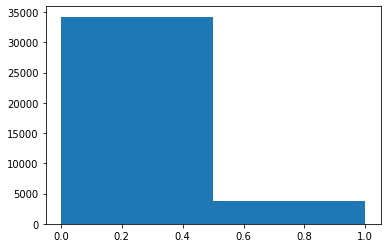

In [8]:
plt.hist(data['dank_level'], bins = 2)

In [13]:
imageDir = '/content/gdrive/My Drive/Colab Notebooks/Memes Project/raw_data/*'
image_files = glob.glob(imageDir)

In [14]:
len(image_files)

37039

In [15]:
image_files[0:2]

['/content/gdrive/My Drive/Colab Notebooks/Memes Project/raw_data/fhmf0n.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Memes Project/raw_data/fhmeyo.jpg']

In [16]:
def getDankLevel(imageLink):
  imgID = imageLink.split('/')[-1].split('.')[0] #find image id based on the file name
  return list(data.loc[data['id'] == imgID]['dank_level'])[0] #look up the dank_level based on the image id
getDankLevel(image_files[1])

0

In [17]:
dank_files = [img for img in image_files if getDankLevel(img) == 1]
not_dank_files = list(set(image_files) - set(dank_files))

#calculating the interval to seperate the train, validation, and test files
interval = len(dank_files)//4 
interval

dank_train = np.random.choice(dank_files, size=2*interval, replace=False)
not_dank_train = np.random.choice(not_dank_files, size=2*interval, replace=False)
dank_files = list(set(dank_files) - set(dank_train))
not_dank_files = list(set(not_dank_files) - set(not_dank_train))

dank_val = np.random.choice(dank_files, size=interval, replace=False)
not_dank_val = np.random.choice(not_dank_files, size=interval, replace=False)
dank_files = list(set(dank_files) - set(dank_val))
not_dank_files = list(set(not_dank_files) - set(not_dank_val))

dank_test = dank_files
not_dank_test = np.random.choice(not_dank_files, size=len(dank_test), replace=False)

#Checking the set sizes
print('Dank datasets:', len(dank_train), len(dank_val), len(dank_test))
print('Not dank datasets:', len(not_dank_train), len(not_dank_val), len(not_dank_test))

Dank datasets: 1878 939 942
Not dank datasets: 1878 939 942


In [18]:
with open('/content/gdrive/My Drive/Colab Notebooks/Memes Project/dank_test_5_threshold.txt', 'w') as outfile:
  outfile.write("\n".join(dank_test))

In [19]:
with open('/content/gdrive/My Drive/Colab Notebooks/Memes Project/not_dank_test_5_threshold.txt', 'w') as outfile:
  outfile.write("\n".join(not_dank_test))

In [20]:
IMG_DIM = (224, 224)
dank_train = [str(item) for item in dank_train] #convert the array to string type
not_dank_train = [str(item) for item in not_dank_train] #convert the array to string type
dank_val = [str(item) for item in dank_val] #convert the array to string type
not_dank_val = [str(item) for item in not_dank_val] #convert the array to string type

train_files = dank_train + not_dank_train
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)

validation_files = dank_val + not_dank_val
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3756, 224, 224, 3) 	Validation dataset shape: (1878, 224, 224, 3)


In [21]:
train_labels = [getDankLevel(fn) for fn in train_files]
validation_labels = [getDankLevel(fn) for fn in validation_files]

(224, 224, 3)


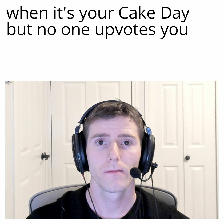

In [22]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [23]:
batch_size = 30
num_classes = 2
epochs = 100
input_shape = (224, 224, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505]) #1 is dank, 0 is not dank

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1 1 1 1 1 1 1 1 1 1]


In [24]:
from keras.models import Model
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)    

58892288/58889256 [==============================] - 6s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


,Layer Type,Layer Name,Layer Trainable
10,<keras.layers.pooling.MaxPooling2D object at 0x7feb1c6560f0>,block3_pool,False
11,<keras.layers.convolutional.Conv2D object at 0x7feb1c656048>,block4_conv1,False
12,<keras.layers.convolutional.Conv2D object at 0x7feb1c654198>,block4_conv2,False
13,<keras.layers.convolutional.Conv2D object at 0x7feb1c651518>,block4_conv3,False
14,<keras.layers.pooling.MaxPooling2D object at 0x7feb1c6509b0>,block4_pool,False
15,<keras.layers.convolutional.Conv2D object at 0x7feb1c650ba8>,block5_conv1,False
16,<keras.layers.convolutional.Conv2D object at 0x7feb1c64e550>,block5_conv2,False
17,<keras.layers.convolutional.Conv2D object at 0x7feb1c64e128>,block5_conv3,False
18,<keras.layers.pooling.MaxPooling2D object at 0x7feb1c64c518>,block5_pool,False
19,<keras.layers.core.Flatten object at 0x7feb1c6182b0>,flatten_1,False


(1, 7, 7, 512)


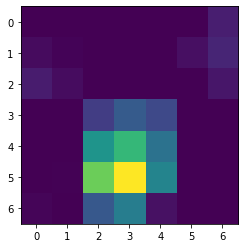

In [25]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [26]:
#unfreeze some layers
vgg_model.trainable = True

retrain_layers = ['block5_conv1', 'block4_conv1']
set_trainable = False
for layer in vgg_model.layers:
    if layer.name in retrain_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)   

,Layer Type,Layer Name,Layer Trainable
10,<keras.layers.pooling.MaxPooling2D object at 0x7feb1c6560f0>,block3_pool,False
11,<keras.layers.convolutional.Conv2D object at 0x7feb1c656048>,block4_conv1,True
12,<keras.layers.convolutional.Conv2D object at 0x7feb1c654198>,block4_conv2,True
13,<keras.layers.convolutional.Conv2D object at 0x7feb1c651518>,block4_conv3,True
14,<keras.layers.pooling.MaxPooling2D object at 0x7feb1c6509b0>,block4_pool,True
15,<keras.layers.convolutional.Conv2D object at 0x7feb1c650ba8>,block5_conv1,True
16,<keras.layers.convolutional.Conv2D object at 0x7feb1c64e550>,block5_conv2,True
17,<keras.layers.convolutional.Conv2D object at 0x7feb1c64e128>,block5_conv3,True
18,<keras.layers.pooling.MaxPooling2D object at 0x7feb1c64c518>,block5_pool,True
19,<keras.layers.core.Flatten object at 0x7feb1c6182b0>,flatten_1,True


In [27]:
# Image Augmentation generator to create variety of images
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)       

In [28]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
              

In [29]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [30]:
history = model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=100,
                              validation_data=val_generator, validation_steps=STEP_SIZE_VALID, 
                              verbose=1)     

Epoch 1/100
125/125 [==============================] - 88s 705ms/step - loss: 0.7169 - accuracy: 0.5043 - val_loss: 0.6916 - val_accuracy: 0.5016
Epoch 2/100
125/125 [==============================] - 85s 677ms/step - loss: 0.6963 - accuracy: 0.5072 - val_loss: 0.6904 - val_accuracy: 0.4989
Epoch 3/100
125/125 [==============================] - 83s 662ms/step - loss: 0.6992 - accuracy: 0.5132 - val_loss: 0.6547 - val_accuracy: 0.5226
Epoch 4/100
125/125 [==============================] - 82s 658ms/step - loss: 0.6951 - accuracy: 0.5201 - val_loss: 0.7129 - val_accuracy: 0.5382
Epoch 5/100
125/125 [==============================] - 82s 656ms/step - loss: 0.6922 - accuracy: 0.5295 - val_loss: 0.6764 - val_accuracy: 0.5565
Epoch 6/100
125/125 [==============================] - 82s 655ms/step - loss: 0.6922 - accuracy: 0.5298 - val_loss: 0.7903 - val_accuracy: 0.5506
Epoch 7/100
125/125 [==============================] - 82s 654ms/step - loss: 0.6927 - accuracy: 0.5220 - val_loss: 0.7410 -

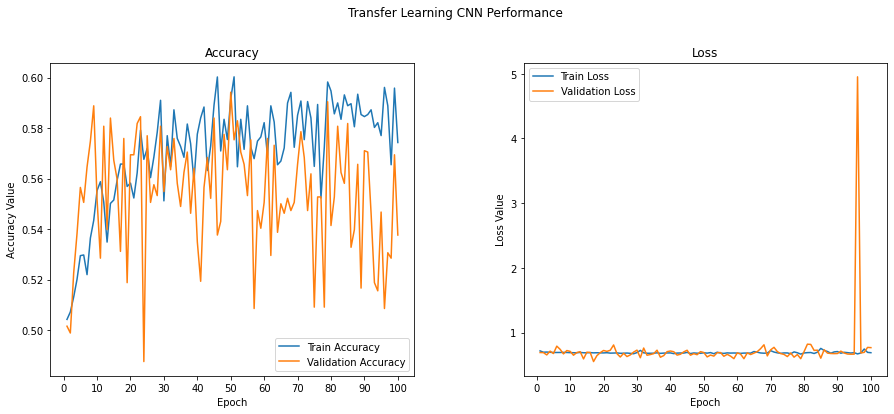

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
t = f.suptitle('Transfer Learning CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [32]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Memes Project/models/finetune_img_aug_vgg16_0.15_5_30_224.h5')

In [33]:
def toString(arr):
  return [str(item) for item in arr]

In [34]:
results = {}
results['epoch_list'] = epoch_list
results['accuracy'] = toString(history.history['accuracy'])
results['val_accuracy'] = toString(history.history['val_accuracy'])
results['val_loss'] = toString(history.history['val_loss'])
results['loss'] = toString(history.history['loss'])

In [35]:
with open('/content/gdrive/My Drive/Colab Notebooks/Memes Project/models/finetune_img_aug_vgg16_0.15_5_30_224_results.json', 'w') as outfile:
  json.dump(results, outfile)